# Introducción al MEF en una dimensión

Autor: Pedro González Rodelas

Fecha de la primera versión: 06/10/2017

Sucesivas revisiones: 08,15/05/2018

Fecha de la última revisión: 22/05/2018

En esta práctica intentaremos mostrar las ideas y técnicas básicas en las que se basa el conocido como Método de los Elementos Finitos en una variable. 

Con el objeto de incidir sólo en las técnicas esenciales y evitar mayores complicaciones de tipo meramente algorítmico, resolveremos un simple problema de contorno de segundo orden, empleando el E.F. de Lagrange lineal. 

No obstante, sí que plantearemos la interesante cuestión de las distintas condiciones de frontera que podríamos considerar, ya sean de tipo Dirichlet, de tipo Neumann o de tipo Robin, homogéneas o no, y cómo se deberían tratar en cada caso.

## Carga de los módulos y Definición de ciertas funciones empleadas

Antes de empezar a realizar cualquier cálculo numérico o simbólico debemos de cargar los correspondientes módulos de Python que implementan la mayoría de funciones y procedimientos necesarios para ello: `NumPy` y `SymPy`, que serán cargados con los pseudónimos np y sp, respectivamente. Además cargaremos el módulo `Matplotlib` que nos permitirá realizar todas las gráficas que los necesitemos.

In [1]:
import numpy as np # Importamos el módulo NumPy con el pseudónimo np
import sympy as sp # Importamos el módulo SymPy con el pseudónimo sp
sp.init_printing() # con esta opción obtendremos bonitas fórmulas

In [2]:
# Importaremos el módulo matplotlib usando una opción concreta que 
# nos permita poder visualizar los gráficos incrustados 
# en línea dentro de este mismo notebook
%matplotlib inline 
import matplotlib.pyplot as plt  # plt será el pseudónimo correspondiente

También definiremos cierta función propia, `mychop`, que nos permitirá cambiar por $0$ cualquier valor que obtengamos, después de ciertos cálculos que involucren errores de redondeo, propios del cálculo con números en coma flotante. 

In [3]:
def mychop(expr, *, max=10**(-15)): 
    if abs(expr) > max:
      return expr 
    else:
      return 0

A su vez usaremos una versión vectorizada de la misma, que podremos aplicar a cualquier lista, tupla o array con valores numéricos en coma flotante.

In [4]:
chop_vec = np.vectorize(mychop)

# Definición de las funciones de base del E.F.

In [5]:
t,z,xL,xR,yL,yR = sp.symbols('t,z,xL,xR,yL,yR')
def linea(z,xL,yL,xR,yR):
    """linea que pasa por los puntos (xL,yL) y (xR,yR)"""
    return yL+(z-xL)*(yL-yR)/(xL-xR)

In [6]:
def l1(t):
    """primera func. de base del E.F. de Lagrange P1 en 1D"""
    return 1-t

def l2(t):
    """segunda func. de base del E.F. de Lagrange P1 en 1D"""
    return t

In [7]:
def dl1(t):
    """derivada de la primera func. de base del E.F. de Lagrange P1 en 1D"""
    return -1

def dl2(t):
    """derivada de la segunda func. de base del E.F. de Lagrange P1 en 1D"""
    return 1

In [8]:
def Finv(z,a,b):
    """afinidad entre cada subintervalo de la partición 
        y el intervalo unidad"""
    return (z-a)/(b-a)

def dFinv(z,a,b):
    """ derivada de la afinidad Finv"""
    return 1/(b-a)

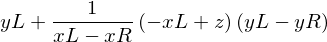

In [9]:
linea(z,xL,yL,xR,yR)  # línea que pasa por dos puntos dados del plano

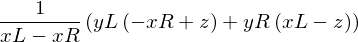

In [10]:
sp.simplify(yL*l1(Finv(z,xL,xR))+yR*l2(Finv(z,xL,xR))) # otra forma
# de resolver este pbma. de interpolación lineal a partir de las 
# funciones de base del E.F. de Lagrange. Comprobación justo abajo

In [11]:
sp.simplify(yL*l1(Finv(z,xL,xR))+yR*l2(Finv(z,xL,xR))
            -linea(z,xL,yL,xR,yR))

In [12]:
nx= 10;  # número de subintervalos de igual longitud a considerar
# definición de las funciones de base del espacio de E.F.
x = np.linspace(0,10,nx+1)  # para esta partición concreta

def wi(z,x,i):  # en los nodos interiores
    """funciones de base del E.F. de Lagrange P1 unidimensional"""
    if (x[i-1]<=z)*(z<=x[i]):
        valor = l2(Finv(z,x[i-1],x[i]))
    elif (x[i]<=z)*(z<=x[i+1]):  
        valor = l1(Finv(z,x[i],x[i+1]))
    else:
        valor = 0
    return valor

def w0(z,x):  # en el extremo izquierdo del intervalo
    """funcion de base del E.F. de Lagrange P1 unidimensional 
    en el extremo izquierdo"""
    if (x[0]<=z)*(z<=x[1]):
        valor = l1(Finv(z,x[0],x[1]))
    else:
        valor = 0
    return valor

def wn(z,x):  # en el extremo derecho del intervalo
    """funcion de base del E.F. de Lagrange P1 unidimensional 
    en el extremo derecho"""
    # recuérdese que x[-1] y x{-2} indican respectivamente el último y penúltimo nodos
    if (x[-2]<=z)*(z<=x[-1]):  
        valor = l2(Finv(z,x[-2],x[-1])) 
    else:
        valor = 0
    return valor

In [13]:
def dwi(z,x,i):  # en los nodos interiores
    """derivadas de las funcs. de base del E.F. de Lagrange P1 1D"""
    if (x[i-1]<=z)*(z<=x[i]):
        valor = dFinv(z,x[i-1],x[i])  #  dl2 = +1
    elif (x[i]<=z)*(z<=x[i+1]):  
        valor = -dFinv(z,x[i],x[i+1]) #  dl1 = -1
    else:
        valor = 0
    return valor

def dw0(z,x):  # en el extremo izquierdo del intervalo
    """derivada de la func. de base del E.F. de Lagrange P1 1D
    en el extremo izquierdo"""
    if (x[0]<=z)*(z<=x[1]):
        valor = -dFinv(z,x[0],x[1])  #  dl1 = -1
    else:
        valor = 0
    return valor

def dwn(z,x):  # en el extremo derecho del intervalo
    """derivada de la func. de base del E.F. de Lagrange P1 1D 
    en el extremo derecho"""
    if (x[-2]<=z)*(z<=x[-1]):         # x[-2]=x[n-1], x[-1]=x[n]
        valor = dFinv(z,x[-2],x[-1])  #  dl2 = +1
    else:
        valor = 0
    return valor

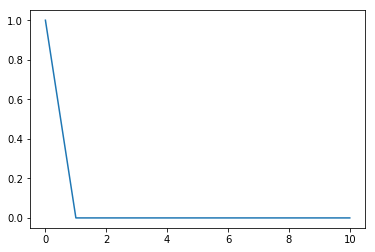

In [14]:
a = 0; b = 10; nxx = 1000;  # Esta segunda partición del intervalo 
xx = np.linspace(a,b,nxx)   # mucho más fina que la anterior                
yy = [w0(z,x) for z in xx]  # tan sólo se usará para poder realizar
plt.plot(xx,yy);            # representaciones gráficas.

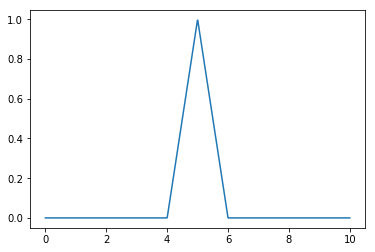

In [15]:
i = nx//2;  # nodo intermedio
xx = np.linspace(a,b,nxx)
yy = [wi(z,x,i) for z in xx]
plt.plot(xx,yy);

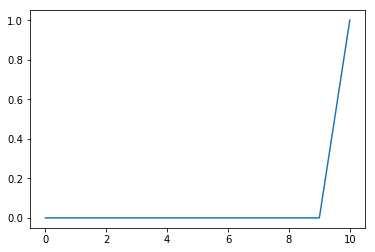

In [16]:
xx = np.linspace(a,b,nxx)    # función de base
yy = [wn(z,x) for z in xx]   # en el nodo derecho
plt.plot(xx,yy);

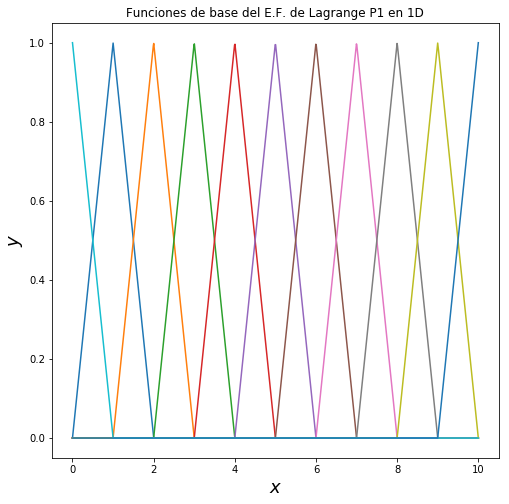

In [17]:
fig,ax = plt.subplots(figsize=(8,8))

for i in range(1,nx):
    yy = [wi(z,x,i) for z in xx]
    plt.plot(xx,yy);
yy = [w0(z,x) for z in xx]
plt.plot(xx,yy);
yy = [wn(z,x) for z in xx]
plt.plot(xx,yy);

ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$y$',fontsize=18)
ax.set_title('Funciones de base del E.F. de Lagrange P1 en 1D');

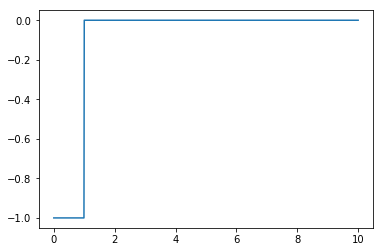

In [18]:
xx = np.linspace(a,b,nxx)    # Función derivada
yy = [dw0(z,x) for z in xx]  # de la función de base
plt.plot(xx,yy);             # en el extremo izqdo.

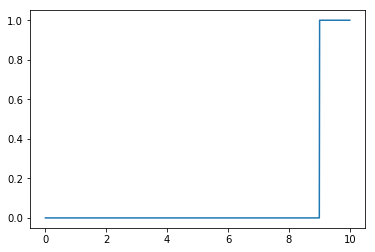

In [19]:
xx = np.linspace(a,b,nxx)      # Función derivada  
yy = [dwn(z,x) for z in xx]    # de la función de base
plt.plot(xx,yy);               # en el extremo dcho.

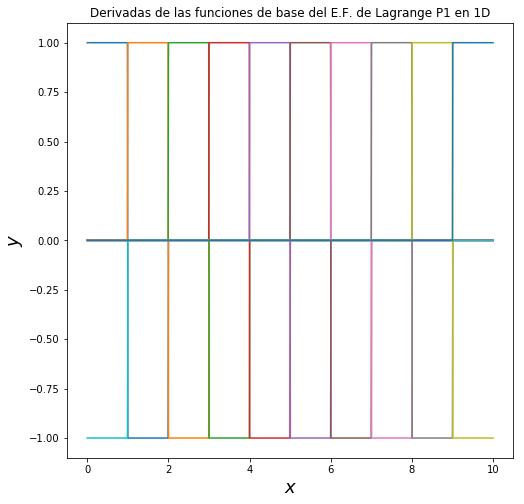

In [20]:
a = 0; b = 10; nxx = 1000;
xx = np.linspace(a,b,nxx)

fig,ax = plt.subplots(figsize=(8,8))

for i in range(1,nx):
    yy = [dwi(z,x,i) for z in xx]
    plt.plot(xx,yy);
yy = [dw0(z,x) for z in xx]
plt.plot(xx,yy);
yy = [dwn(z,x) for z in xx]
plt.plot(xx,yy);

ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$y$',fontsize=18)
ax.set_title('Derivadas de las funciones de base del E.F. de Lagrange P1 en 1D');

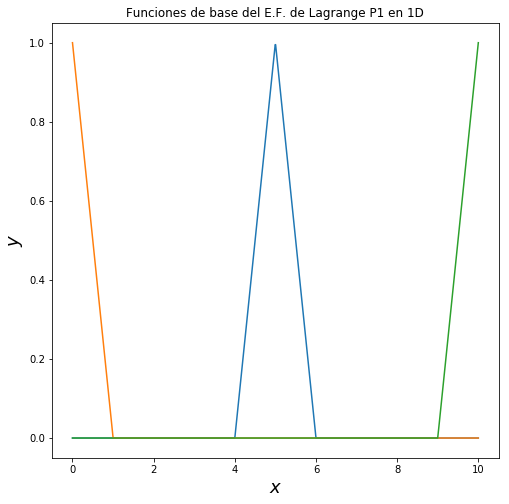

In [21]:
a = 0; b = 10; nxx = 1000;
xx = np.linspace(a,b,nxx)

fig,ax = plt.subplots(figsize=(8,8))

i=nx//2;  # nodo intermedio
yy = [wi(z,x,i) for z in xx]
plt.plot(xx,yy);
yy = [w0(z,x) for z in xx]
plt.plot(xx,yy);
yy = [wn(z,x) for z in xx]
plt.plot(xx,yy);

ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$y$',fontsize=18)
ax.set_title('Funciones de base del E.F. de Lagrange P1 en 1D');

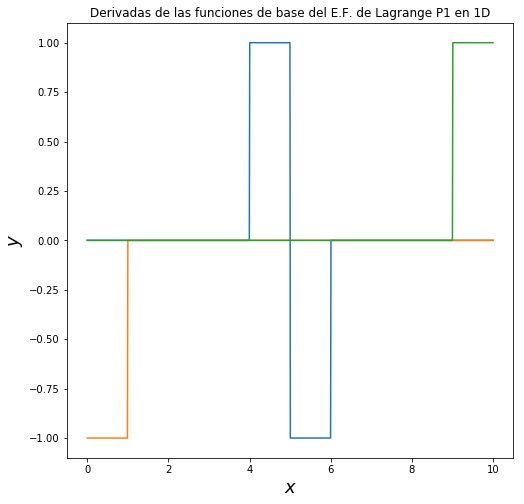

In [22]:
nxx = 1000;
xx = np.linspace(a,b,nxx)

fig,ax = plt.subplots(figsize=(8,8))

i=nx//2; # nodo intermedio
yy = [dwi(z,x,i) for z in xx]
plt.plot(xx,yy);
yy = [dw0(z,x) for z in xx]
plt.plot(xx,yy);
yy = [dwn(z,x) for z in xx]
plt.plot(xx,yy);

ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$y$',fontsize=18)
ax.set_title('Derivadas de las funciones de base del E.F. de Lagrange P1 en 1D');

Veámos ahora cómo influye el valor del paso uniforme de la partición $h$ en los valores de la derivada constante a trozos.

h = 0.1


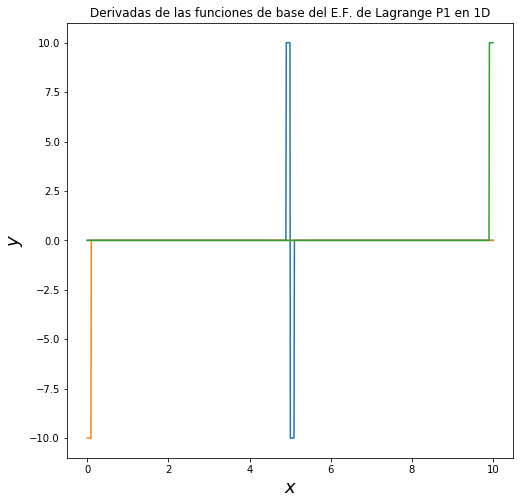

In [23]:
# bastará probar con distintos valores de nx
nx = 100; print('h =',(b-a)/nx) 
x = np.linspace(a,b,nx+1)
nxx = 1000;
xx = np.linspace(a,b,nxx)

fig,ax = plt.subplots(figsize=(8,8))

i=nx//2;
yy = [dwi(z,x,i) for z in xx]
plt.plot(xx,yy);
yy = [dw0(z,x) for z in xx]
plt.plot(xx,yy);
yy = [dwn(z,x) for z in xx]
plt.plot(xx,yy);

ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$y$',fontsize=18)
ax.set_title('Derivadas de las funciones de base del E.F. de Lagrange P1 en 1D');

# Recordatorio sobre los splines lineales

Antes de continuar con el empleo de la técnica de los elementos finitos para la resolución numérica de ciertas ecuaciones diferenciales, vamos a recordar brevemente cómo estas mismas funciones de base del E.F. de Lagrange lineal se podían usar como base de los correspondientes splines lineales $S_1(a,x_1,\ldots,x_{n-1},b)$ y por lo tanto se podrán usar para resolver cualquier problema de interpolación de Lagrange con datos dados sobre los nodos de dicha partición. 

h = 1.0


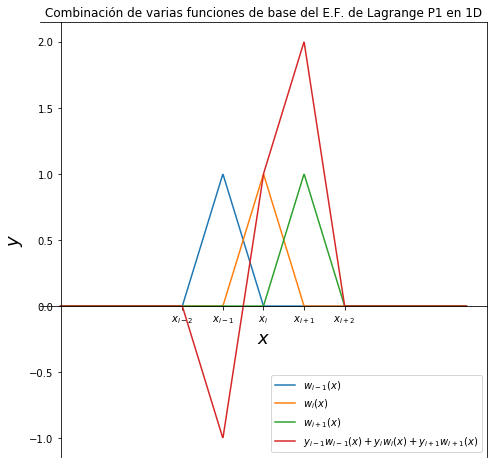

In [24]:
a = 0; b = 10;
nx = 10; nxx = 1000;
print('h =',(b-a)/nx) 
x = np.linspace(a,b,nx+1)
xx = np.linspace(a,b,nxx)

fig,ax = plt.subplots(figsize=(8,8))

i=nx//2;  # nodo intermedio
yy = [wi(z,x,i-1) for z in xx]
plt.plot(xx,yy,label='$w_{i-1}(x)$');
yy = [wi(z,x,i) for z in xx]
plt.plot(xx,yy,label='$w_i(x)$');
yy = [wi(z,x,i+1) for z in xx]
plt.plot(xx,yy,label='$w_{i+1}(x)$');

ax.set_xticks([x[i-2],x[i-1], x[i], x[i+1], x[i+2]])
ax.set_xticklabels(['$x_{i-2}$','$x_{i-1}$','$x_{i}$','$x_{i+1}$','$x_{i+2}$'], fontsize=18)
ax.spines['bottom'].set_position(('data',0)) 
ax.spines['left'].set_position(('data',0))

ym = -1; yi = 1; yp =2; # cambie estos valores para ver el efecto final
yy = [ym*wi(z,x,i-1)+yi*wi(z,x,i)+yp*wi(z,x,i+1) for z in xx]
plt.plot(xx,yy,label='$y_{i-1}w_{i-1}(x)+y_{i}w_{i}(x)+y_{i+1}w_{i+1}(x)$');
ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$y$',fontsize=18)
ax.legend(loc=4)
ax.set_title('Combinación de varias funciones de base del E.F. de Lagrange P1 en 1D');

In [25]:
fig.savefig("CombBaseEF.pdf")

In [26]:
ls CombBaseEF.*

 El volumen de la unidad C es Windows
 El número de serie del volumen es: C6F4-3FE3

 Directorio de C:\Users\prode\Downloads\TallerPythonUGR-master\TallerPythonUGR-master\notebooks_adicionales

06/09/2018  23:06            16.096 CombBaseEF.pdf
               1 archivos         16.096 bytes
               0 dirs  87.529.308.160 bytes libres


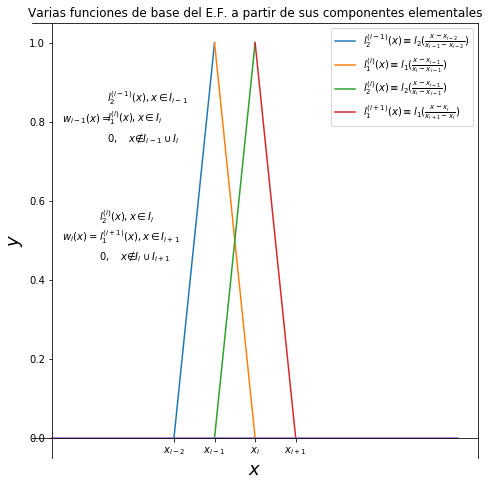

In [27]:
a = 0; b = 10; nxx = 1000;

fig,ax = plt.subplots(figsize=(8,8))

i=nx//2;  # nodo intermedio

xx = np.linspace(x[i-2],x[i-1],nxx)
yy = [l2(Finv(z,x[i-2],x[i-1])) for z in xx]
plt.plot(xx,yy,label=r'$l_2^{(i-1)}(x)\equiv l_2(\frac{x-x_{i-2}}{x_{i-1}-x_{i-2}})$');

xx = np.linspace(x[i-1],x[i],nxx)

yy = [l1(Finv(z,x[i-1],x[i])) for z in xx]
plt.plot(xx,yy,label=r'$l_1^{(i)}(x)\equiv l_1(\frac{x-x_{i-1}}{x_{i}-x_{i-1}})$');

yy = [l2(Finv(z,x[i-1],x[i])) for z in xx]
plt.plot(xx,yy,label=r'$l_2^{(i)}(x)\equiv l_2(\frac{x-x_{i-1}}{x_{i}-x_{i-1}})$');

xx = np.linspace(x[i],x[i+1],nxx)
yy = [l1(Finv(z,x[i],x[i+1])) for z in xx]
plt.plot(xx,yy,label=r'$l_1^{(i+1)}(x)\equiv l_1(\frac{x-x_{i}}{x_{i+1}-x_{i}})$');

ax.set_xticks([x[i-2],x[i-1], x[i], x[i+1]])
ax.set_xticklabels(['$x_{i-2}$','$x_{i-1}$', '$x_{i}$', '$x_{i+1}$'], fontsize=18)
ax.spines['bottom'].set_position(('data',0)) 
ax.spines['left'].set_position(('data',0))   

xx = np.linspace(a,b,nxx)
yy = np.zeros(nxx)
ax.plot(xx,yy)

ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$y$',fontsize=18)
ax.legend(loc=1)

ax.text(1.35, 0.85, r"$l_2^{(i-1)}(x), x\in I_{i-1}$")
ax.text(1.35, 0.8, r"$l_1^{(i)}(x), x\in I_{i}$")
ax.text(1.35, 0.75, r"$0,\quad x\notin I_{i-1}\cup I_{i}$")
ax.text(.25, 0.8, r"$w_{i-1}(x)=  $")

ax.text(1.15, 0.55, r"$l_2^{(i)}(x), x\in I_{i}$")
ax.text(1.15, 0.5, r"$l_1^{(i+1)}(x), x\in I_{i+1}$")
ax.text(1.15, 0.45, r"$0,\quad x\notin I_{i}\cup I_{i+1}$")
ax.text(.25, 0.5, r"$w_{i}(x)=  $")


ax.set_title('Varias funciones de base del E.F. a partir de sus componentes elementales');

In [28]:
fig.savefig("FuncBaseEF.pdf")

In [29]:
ls FuncBaseEF.*

 El volumen de la unidad C es Windows
 El número de serie del volumen es: C6F4-3FE3

 Directorio de C:\Users\prode\Downloads\TallerPythonUGR-master\TallerPythonUGR-master\notebooks_adicionales

06/09/2018  23:06            18.406 FuncBaseEF.pdf
               1 archivos         18.406 bytes
               0 dirs  87.529.226.240 bytes libres


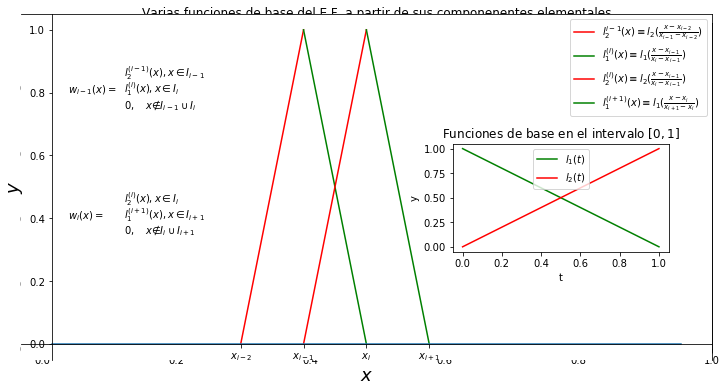

In [30]:
a = 0; b = 10; nxx = 1000;

fig,ax = plt.subplots(figsize=(12,6))

ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # ejes principales
ax2 = fig.add_axes([0.6, 0.35, 0.25, 0.25]) # ejes añadidos

# figura insertada
xx = np.linspace(0,1,nxx)
ax2.plot(xx, 1-xx, 'g',label='$l_1(t)$')
ax2.plot(xx, xx, 'r',label='$l_2(t)$')
ax2.set_xlabel('t')
ax2.set_ylabel('y')
ax2.legend(loc=9)
ax2.set_title('Funciones de base en el intervalo $[0,1]$');

i=nx//2;  # nodo intermedio

xx = np.linspace(x[i-2],x[i-1],nxx)
yy = [l2(Finv(z,x[i-2],x[i-1])) for z in xx]
ax1.plot(xx,yy,'r',label=r'$l_2^{i-1}(x)\equiv l_2(\frac{x-x_{i-2}}{x_{i-1}-x_{i-2}})$');

xx = np.linspace(x[i-1],x[i],nxx)

yy = [l1(Finv(z,x[i-1],x[i])) for z in xx]
ax1.plot(xx,yy,'g',label=r'$l_1^{(i)}(x)\equiv l_1(\frac{x-x_{i-1}}{x_{i}-x_{i-1}})$');

yy = [l2(Finv(z,x[i-1],x[i])) for z in xx]
ax1.plot(xx,yy,'r',label=r'$l_2^{(i)}(x)\equiv l_2(\frac{x-x_{i-1}}{x_{i}-x_{i-1}})$');

xx = np.linspace(x[i],x[i+1],nxx)
yy = [l1(Finv(z,x[i],x[i+1])) for z in xx]
ax1.plot(xx,yy,'g',label=r'$l_1^{(i+1)}(x)\equiv l_1(\frac{x-x_{i}}{x_{i+1}-x_{i}})$');

ax1.set_xticks([x[i-2], x[i-1], x[i], x[i+1]])
ax1.set_xticklabels(['$x_{i-2}$', '$x_{i-1}$', '$x_{i}$', '$x_{i+1}$'], fontsize=18)
ax1.spines['bottom'].set_position(('data',0)) 
ax1.spines['left'].set_position(('data',0))   

xx = np.linspace(a,b,nxx)
yy = np.zeros(nxx)
ax1.plot(xx,yy)

ax1.set_xlabel('$x$',fontsize=18)
ax1.set_ylabel('$y$',fontsize=18)
ax1.legend(loc=1)

ax1.text(1.15, 0.85, r"$l_2^{(i-1)}(x), x\in I_{i-1}$")
ax1.text(1.15, 0.8, r"$l_1^{(i)}(x), x\in I_{i}$")
ax1.text(1.15, 0.75, r"$0,\quad x\notin I_{i-1}\cup I_{i}$")
ax1.text(.25, 0.8, r"$w_{i-1}(x)=  $")

ax1.text(1.15, 0.45, r"$l_2^{(i)}(x), x\in I_{i}$")
ax1.text(1.15, 0.4, r"$l_1^{(i+1)}(x), x\in I_{i+1}$")
ax1.text(1.15, 0.35, r"$0,\quad x\notin I_{i}\cup I_{i+1}$")
ax1.text(.25, 0.4, r"$w_{i}(x)=  $")


ax.set_title('Varias funciones de base del E.F. a partir de sus componenentes elementales');

In [31]:
fig.savefig("FuncBaseEFbis.pdf")

In [32]:
ls FuncBaseEFbis.*

 El volumen de la unidad C es Windows
 El número de serie del volumen es: C6F4-3FE3

 Directorio de C:\Users\prode\Downloads\TallerPythonUGR-master\TallerPythonUGR-master\notebooks_adicionales

06/09/2018  23:06            21.062 FuncBaseEFbis.pdf
               1 archivos         21.062 bytes
               0 dirs  87.529.222.144 bytes libres


In [33]:
def f(z):
    return np.sin(z)

In [34]:
nx = 10; print('h =',(b-a)/nx) 
x = np.linspace(a,b,nx+1)
y = [f(z) for z in x]

h = 1.0


In [35]:
xx = np.linspace(a,b,nxx)
yf = f(xx)

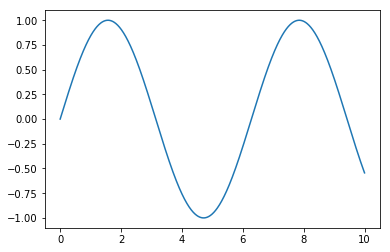

In [36]:
plt.plot(xx,yf);

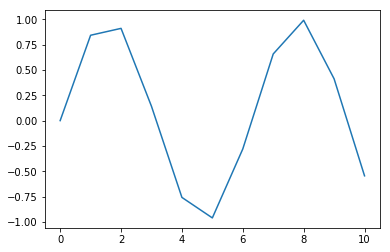

In [37]:
plt.plot(x,y);

In [38]:
len(x),len(y)

In [39]:
y

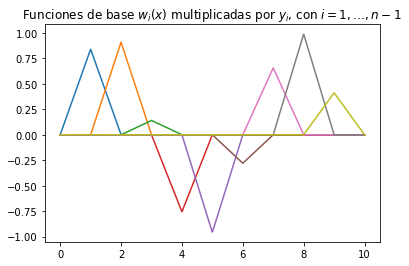

In [40]:
yy = [[wi(z,x,i)*y[i] for i in range(1,nx)] for z in xx]
plt.plot(xx,yy);
plt.title('Funciones de base $w_i(x)$ multiplicadas por $y_i$, con $i=1,\ldots,n-1$');

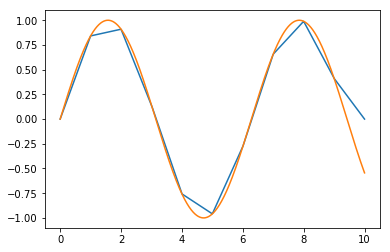

In [41]:
yy = np.array([sum([wi(z,x,i)*y[i] for i in range(1,nx)]) for z in xx])
plt.plot(xx,yy);  # ¡nótese lo que ocurre en el extremo derecho!
yf = [f(z) for z in xx]
plt.plot(xx,yf);

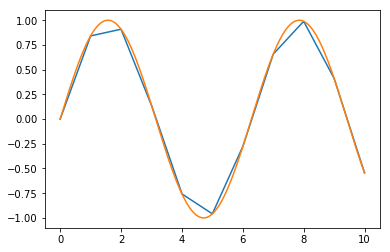

In [42]:
# al no ser nulo el valor en dicho extremo, tendremos que añadir un 
# sumando más, con wn(z,x) multiplicada por el valor correspondiente
yy = yy + np.array([wn(z,x)*y[-1] for z in xx])
plt.plot(xx,yy); # ahora ya si se tiene resuelto el problema de
plt.plot(xx,yf); # interpolación lagrangiana con el spline lineal

# Planteamiento del problema diferencial de 2º orden a resolver

Supongamos que queremos resolver un problema de contorno de segundo orden muy sencillo, con condiciones de tipo Dirichlet en los extremos de cierto intervalo $[a,b]$; pongamos por ejemplo

$$-y''(x) = f(x), \; x\in [a,b]\\
y(a) = y_a,\quad y(b)=y_b$$

para cierta función $f(x)$ contínua en dicho intervalo. Tomemos por ejemplo $f(x)=\sin(x),\; x\in[0,10]$ para empezar.

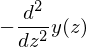

In [43]:
y,z = sp.symbols('y,z')
def L(y,z): # usaremos la variable z como variable independiente
    """operador diferencial que define la ec. dif."""
    return -sp.diff(y(z),z,2)
L(y,z)  

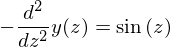

In [44]:
# z = sp.Symbol('z')
def f(z):
    """función del segundo término de la ec. diferencial"""
    return sp.sin(z)

sp.Eq(L(y,z),f(z)) #  ec. diferencial que estamos considerando 

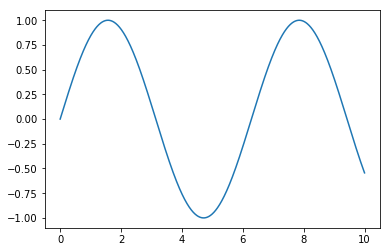

In [45]:
a = 0; b = 10; nxx = 1000;
xx = np.linspace(a,b,nxx+1)
yf = [f(z) for z in xx]
plt.plot(xx,yf);

Empezaremos resolviendo esta ecuación diferencial usando las herramientas de cálculo simbólico de las que dispone Python, incluidas en el módulo SymPy, concretamente en este caso `dsolve`.

In [46]:
g = f(z)
solgen = sp.dsolve(sp.Eq(-y(z).diff(z,2), g))
solgen

In [47]:
ecs= solgen.subs({z:a}),solgen.subs({z:b})
ecs

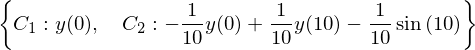

In [48]:
C1,C2 = sp.symbols('C1,C2')
sp.solve(ecs,[C1,C2])

In [49]:
print(solgen)

Eq(y(z), C1 + C2*z + sin(z))


In [50]:
ya,yb = sp.symbols('ya,yb')
ecsbis = (C1 + C2*z + sp.sin(z)).subs({z:a})-ya,(C1 + C2*z + sp.sin(z)).subs({z:b})-yb
ecsbis

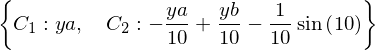

In [51]:
sp.solve(ecsbis,[C1,C2])

In [52]:
print(_)

{C1: ya, C2: -ya/10 + yb/10 - sin(10)/10}


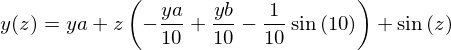

In [53]:
solgen.subs({C1:ya,C2:-ya/10 + yb/10 - sp.sin(10)/10})

In [54]:
def yexacta(z,ya,yb):
    """solución exacta del problema tomado como ejemplo"""
    return ya + 1/b*(yb-ya-sp.sin(b))*z+sp.sin(z)

In [55]:
ya = 0; yb = 10;  # para estas condiciones dadas
yexacta(z,ya,yb) # esta sería pues la solución exacta del problema

In [56]:
# comprobación
sp.diff(yexacta(z,ya,yb),z,2),yexacta(a,ya,yb),yexacta(b,ya,yb)

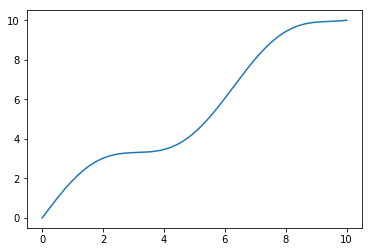

In [57]:
yyexacta = [yexacta(z,ya,yb) for z in xx] 
plt.plot(xx,yyexacta); # gráfica de la solución exacta

Así pues, vemos perfectamente que una vez conocidas las condiciones de contorno de tipo Dirichlet en ambos extremos, $y(a)=y_a$ e $y(b)=y_b$, tendremos perfectamente resuelto, analíticamente en este caso, nuestro problema de contorno. Pero no siempre es posible obtener analíticamente la solución exacta de uno de estos problemas y por ello conviene disponer de algún método numérico eficiente que nos permita al menos aproximar dicha solución con determinado grado de precisión. En esta práctica nos centraremos en el denominado método de los Elementos Finitos (E.F) en una sóla variable, del que introduciremos las técnicas e ideas básicas, para su posterior desarrollo más general en el caso de varias variables.

## Matriz de rígidez local en el E.F. de referencia

In [58]:
l1(t),l2(t)  # funciones de base del E.F. de Lagrange lineal en [0,1]

In [59]:
# calculamos ahora las correspondientes integrales en el intervalo
a00 = sp.integrate(dl1(t)**2,[t,0,1])        # de referencia [0,1]
a01 = sp.integrate(dl1(t)*dl2(t),[t,0,1])
a11 = sp.integrate(dl2(t)**2,[t,0,1])

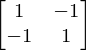

In [60]:
Aref = sp.Matrix([[a00,a01],[a01,a11]]) # esta sería la matriz de rigidez local 
Aref  # en el intervalo de referencia [0,1]

In [61]:
a00 = sp.integrate((dl1(Finv(z,xL,xR))*dFinv(z,xL,xR))**2,[z,xL,xR])
a01 = sp.integrate(dl1(Finv(z,xL,xR))*dl2(Finv(z,xL,xR))*dFinv(z,xL,xR)**2,[z,xL,xR])
a11 = sp.integrate((dl2(Finv(z,xL,xR))*dFinv(z,xL,xR))**2,[z,xL,xR])

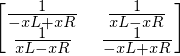

In [62]:
Agen = sp.Matrix([[a00,a01],[a01,a11]])
Agen = sp.simplify(Agen) # y esta sería la correspondiente matriz
Agen # de rigidez local en un intervalo genérico [xL,xR]

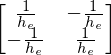

In [63]:
h_e = sp.Symbol('h_e') # ahora sustituiremos xR-xL por he, una
Agen = Agen.subs({xL-xR:-h_e,-xL+xR:h_e}) # longitud genérica
Agen

## Ensamblaje de la matriz de rígidez  global

In [64]:
nx = 10;  # ahora nos planteamos el cálculo de 
x = np.linspace(a,b,nx+1)  # la matriz de rigidez global

In [65]:
A = np.zeros((nx-1,nx-1),dtype=float)
np.shape(A)
# print(A)

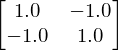

In [66]:
i=1; Agen.subs({h_e:x[i]-x[i-1]})

In [67]:
[i for i in range(1,nx)]

In [68]:
# primero calcularemos los elementos de la diagonal principal
for i in range(1,nx): 
    A[i-1,i-1] = Agen[1,1].subs({h_e:x[i]-x[i-1]})+Agen[0,0].subs({h_e:x[i+1]-x[i]})

In [69]:
for i in range(1,nx-1): # y ahora la diagonal inferior adyacente
    A[i-1,i] = Agen[0,1].subs({h_e:x[i+1]-x[i]})
    A[i,i-1] = A[i-1,i] # aprovechando la simetría de la matriz

In [70]:
print(A) # esta sería la matriz de rigidez global en este caso

[[ 2. -1.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  2. -1.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  2. -1.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  2. -1.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  2. -1.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  2. -1.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  2. -1.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  2. -1.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  2.]]


## Ensamblaje del vector de cargas

In [71]:
# cargaremos previamente la orden de integración numérica 'quad' 
# de la que dispone Python dentro del submódulo 'integrate' de SciPy 
from scipy.integrate import quad  # 

In [72]:
quad(f, a, b) # el primer término es la aproximación numérica de la
# integral, mientras que el segundo una estimación del error cometido

In [73]:
i=1; # pequeña prueba de cómo usar funciones lambda
g = lambda z: f(z)*l2(Finv(z,x[i-1],x[i])) # dentro de 'quad'
quad(g,x[i-1],x[i])[0]

In [74]:
p1  = ya+(yb-ya)/(b-a)*(z-a)  # este cambio permitiría homogeneizar
p1 # las dos condiciones de contorno de tipo Dirichlet impuestas
yyp1 = np.array([p1.subs({z:x}) for x in xx])

In [75]:
# esta nueva función en el segundo miembro de la ec. diferencial
def fbis(z): # permite considerar condiciones de frontera homogéneas
    return (f(t)-L(lambda t:p1,t)).subs({t:z})

Pero vemos que al ser $p_1(x)$ una función lineal, su derivada segunda siempre será nula, por lo que en este caso particular no cambiará para nada la función del segundo miembro de nuestra ec. diferencial. No obstante, cuando se consideren otros operadores autoadjuntos más generales, de la forma  (con funciones $p\in\mathcal{C}^1$ y $q\in\mathcal{C}^0$)
$$\mathcal{L}(y)\equiv -(p(x)y')'+q(x)y$$
entonces sí que tendríamos que 
$$\mathcal{L}(p_1) = -(p'(x)p_1'+p(x)p_1'')+q(x)p_1=-p'(x)p_1'+q(x)p_1$$ pero para nuestra ecuación diferencial del ejemplo que estamos considerando, resulta que $p(x)\equiv 1$ y $q(x)\equiv 0$ y por eso nos ha salido $\mathcal{L}(p_1) = 0$ en este caso particular.

In [76]:
B = np.zeros(nx-1)
len(B)
# B

In [77]:
for i in range(1,nx):  # Atención: ¡cuidado con los índices en Python!
    intizda = quad(lambda z:fbis(z)*l2(Finv(z,x[i-1],x[i])),x[i-1],x[i])
    intdcha = quad(lambda z:fbis(z)*l1(Finv(z,x[i],x[i+1])),x[i],x[i+1])
    B[i-1] = intizda[0] + intdcha[0]
print(B)

[ 0.77364454  0.83600386  0.12974508 -0.69580072 -0.88163056 -0.25689332
  0.60403045  0.90961141  0.37889983]


In [78]:
# descartamos la integración simbólica de estos términos porque
# tardaría muchísimo más en calcularse
#for i in range(1,nx):  
#    intizda = sp.integrate(f(z)*l2(Finv(z,x[i-1],x[i])),[z,x[i-1],x[i]])
#    intdcha = sp.integrate(f(z)*l1(Finv(z,x[i],x[i+1])),[z,x[i],x[i+1]])
#    B[i-1] = intizda + intdcha

## Resolución del sistema lineal y construcción de la solución aproximada del problema

In [79]:
# comprobación de las dimensiones de la matriz A y del vector B
len(A),len(B)

In [80]:
C = np.linalg.solve(A,B) # resolución del sistema lineal asociado

In [81]:
C  # esta sería la solución de dicho sistema

array([ 0.8958731 ,  1.01810165,  0.30432634, -0.53919405, -0.68691372,
        0.04699717,  1.03780138,  1.42457514,  0.90173749])

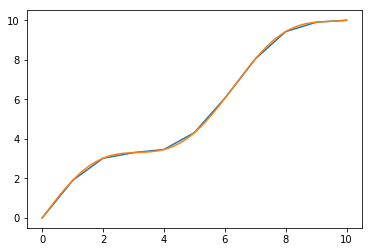

In [82]:
yy = np.array([sum([wi(z,x,i)*C[i-1] for i in range(1,nx)]) for z in xx])
# yy = yy +    ya*np.array([w0(z,x) for z in xx]) 
# yy = yy +    yb*np.array([wn(z,x) for z in xx])
# plt.plot(xx,yy); # nótese que habrá que sumar p1(z) para que se 
plt.plot(xx,yy + yyp1); # satisfagan las condiciones de contorno
yyexacta = [yexacta(z,ya,yb) for z in xx] 
plt.plot(xx,yyexacta);  # y aproximar la solución exacta del pbma.

# Caso de condiciones de tipo Neumann

Resolveremos ahora otro problema de contorno de segundo orden como el anterior, pero con alguna de las condiciones de tipo Neumann, aunque la otra siga siendo de tipo Dirichlet en alguno de los dos extremos de cierto intervalo $[a,b]$, con lo cuál el problema sigue teniendo solución única; pongamos por ejemplo

$$-y''(x) = f(x), \; x\in [a,b]\\
y(a) = y_a,\quad y'(b)=y_b^1$$

para cierta función $f(x)$ contínua en dicho intervalo. Seguiremos tomando $f(x)=\sin(x),\; x\in[0,10]$ como antes.

In [83]:
solgen  # la solución general de la ec. diferencial era

In [84]:
print(solgen)

Eq(y(z), C1 + C2*z + sin(z))


In [85]:
print(sp.diff(C1 + C2*z + sp.sin(z),z)) # usaremos la variable z
# que ya la teníamos definida como simbólica, y x era un array

C2 + cos(z)


In [86]:
ya,dyb = sp.symbols('ya,dyb')
ecs = (C1 + C2*z + sp.sin(z)).subs({z:a})-ya,(C2 + sp.cos(z)).subs({z:b})-dyb
ecs

In [87]:
solgen.subs({C1:ya,C2:dyb-sp.cos(b)})

In [88]:
print(_)

Eq(y(z), ya + z*(dyb - cos(10)) + sin(z))


In [89]:
def yexacta(z,ya,dyb):
    """solución exacta del problema tomado como ejemplo"""
    return ya + z*(dyb - sp.cos(10)) + sp.sin(z)

In [90]:
ya = -1; dyb = 1
yexacta(z,ya,dyb)

In [91]:
-sp.diff(yexacta(z,ya,dyb),z,2) # comprobando si se satisface la E.D.O.

In [92]:
yexacta(z,ya,dyb).subs({z:a})  # comprobando la condición de contorno
# de tipo Dirichlet en el extremo izquierdo del intervalo

In [93]:
sp.diff(yexacta(z,ya,dyb),z).subs({z:b})  # comprobando la condición 
# de contorno de tipo Neumann en el extremo derecho del intervalo

In [94]:
yexacta(a,ya,dyb),sp.diff(yexacta(z,ya,dyb),z).subs({z:b})

In [95]:
p1  = ya+dyb*(z-a)  # este cambio permitiría homogeneizar
p1                  # ambas condiciones de contorno impuestas

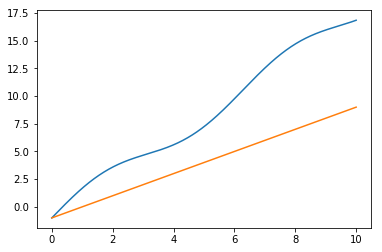

In [96]:
yyexacta = [yexacta(z,ya,dyb) for z in xx] 
yyp1     = [p1.subs({z:zz}) for zz in xx] 
plt.plot(xx,yyexacta);
plt.plot(xx,yyp1); # la condición de la derecha involucra sólo a la
# derivada primera, por lo que los valores de y(b) y p1(b) no tienen 
# porque coincidir, sólo tienen que tener la misma pendiente en x =b
# de manera que y(z)-p1(z) satisfará el mismo tipo de condiciones de 
# contorno, pero con datos homogéneos (es decir, nulos).

Si escribimos la posible solución 
$$\widetilde{y}_h(x) \equiv p_1(x)+\widehat{z}_h(x)
    \equiv y_a+(x-a)y_b^1+\sum_{j=1}^n c_j w_j(x)$$
   
al introducir esta expresión en la formulación variacional del problema con condiciones de tipo Neumann, se deberá satisfacer, para cualquier función test en el espacio 
$$\mathcal{D}_h\equiv\left\{ v\in S_1(a,x_1,\ldots,x_n),\; : v(a)=0 \right\}$$

$$\mathcal{A}(\widetilde{y}_h,v)=\mathcal{B}_f(v)+v(b)y_b^1$$

o considerando sólo funciones de la base del espacio discreto $\mathcal{D}_h = gen\left\{ w_i,\; i=1,\ldots,n\right\}$ 

$$\mathcal{A}(\widehat{z}_h,w_i)=\mathcal{B}_f(w_i)+w_i(b)y_b^1-\mathcal{A}(p_1,w_i)$$

pero, como se puede comprobar fácilmente, para todo $i=1,\ldots,n-1$, $w_i(b)=0$, y 
$$\mathcal{A}(p_1,w_i)=\int_{x_{i-1}}^{x_{i}}\frac{y_b^1}{x_i-x_{i-1}}\,dx +\int_{x_{i}}^{x_{i+1}} \frac{-y_b^1}{x_{i+1}-x_{i}}\,dx=y_b^1\left(1-1\right)=0$$
mientras que para $i=n$ se tiene también que 

$$w_n(b)y_b^1-\mathcal{A}(p_1,w_n)=y_b^1-\int_{x_{n-1}}^{x_{n}}\frac{y_b^1}{x_n-x_{n-1}}\,dx = y_b^1\left(1-1\right)=0$$

Así pues, bastaría con resolver aproximadamente el problema con condiciones homogéneas 

$$-z''(x) = f(x), \; x\in [a,b]\\
z(a) = 0,\quad z'(b)= 0$$

y a la aproximación obtenida, $\widehat{z}_h(x)$ sumarle simplemente $p_1(x)$ para obtener la aproximación buscada del problema original
$\widetilde{y}_h(x) \equiv p_1(x)+\widehat{z}_h(x)$.

Nótese sin embargo que, en caso de que el operador diferencial hubiese sido un operador diferencial autoadjunto general, con $q(x)\neq 0$ o bien con  $p(x)$ no constante, entonces sí que habría que haber modificado ligeramente el vector de términos independientes del sistema lineal.

In [97]:
fbis = f(z)-L(lambda z:p1,z) # esta nueva función en el segundo 
fbis # miembro de la ec. dif. permite considerar condiciones de 
# frontera del mismo tipo que de partida, pero homogéneas

In [98]:
# esta nueva función en el segundo miembro de la ec. diferencial
def fbis(z): # permite considerar condiciones de frontera homogéneas
    return (f(t)-L(lambda t:p1,t)).subs({t:z})

## Ensamblaje de la matriz de rigidez

In [99]:
nx = 10; x = np.linspace(a,b,nx+1)
x

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.])

In [100]:
A = np.zeros((nx,nx),dtype=float)
np.shape(A)
# print(A)

In [101]:
for i in range(1,nx): # ¡Atención con los índices en Python!
# hemos empezado con los elementos de la diagonal principal de la 
# matriz de rigidez, con índices desde 0 hasta nx-2.   
    A[i-1,i-1] = Agen[1,1].subs({h_e:x[i]-x[i-1]})+Agen[0,0].subs({h_e:x[i+1]-x[i]})
A[nx-1,nx-1]   = Agen[1,1].subs({h_e:x[nx]-x[nx-1]})  
# pero el caso nx-1 es especial y hay que definirlo aparte

In [102]:
for i in range(1,nx): # ahora nos encargamos de la diagonal inferior
    A[i-1,i] = Agen[0,1].subs({h_e:x[i+1]-x[i]})
    A[i,i-1] = A[i-1,i] # y de la superior por simetría
print(A)    

[[ 2. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  2. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  2. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  2. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  2. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  2. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  2. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  2. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  2. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  1.]]


In [103]:
B = np.zeros(nx) # Ahora empezamos a construir el array correspondiente
print(B)         # al vector de términos independientes del sist. lineal
                 # con valores nulos en un primer momento.

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [104]:
len(B)         # comprobamos que efectivamente tendremos nx incógnitas

In [105]:
B[0],B[nx-1]    # ¡recuérde que en Python el primer índice es el 0!

In [106]:
x[0],x[nx]      # estos deberán ser los extremos del intervalo [a,b]

In [107]:
for i in range(1,nx):  # Atención: ¡cuidado con los índices en Python!
    intizda = quad(lambda z:fbis(z)*l2(Finv(z,x[i-1],x[i])),x[i-1],x[i])
    intdcha = quad(lambda z:fbis(z)*l1(Finv(z,x[i],x[i+1])),x[i],x[i+1])
    B[i-1] = intizda[0] + intdcha[0]
B[nx-1] = quad(lambda z:f(z)*l2(Finv(z,x[nx-1],x[nx])),x[nx-1],x[nx])[0]  
print(B)

[ 0.77364454  0.83600386  0.12974508 -0.69580072 -0.88163056 -0.25689332
  0.60403045  0.90961141  0.37889983 -0.11706807]


## Resolución del sistema lineal y construcción de la solución aproximada del problema

In [108]:
C = np.linalg.solve(A,B)

In [109]:
C

array([ 1.68054251,  2.58744048,  2.6583346 ,  2.59948362,  3.23643337,
        4.75501368,  6.5304873 ,  7.70193048,  7.96376225,  7.84669418])

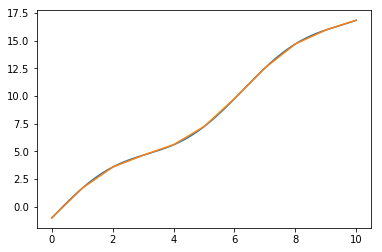

In [110]:
yy = np.array([sum([wi(z,x,i)*C[i-1] for i in range(1,nx)]) for z in xx])
yy = yy + C[-1]*np.array([wn(z,x) for z in xx])
# plt.plot(xx,yy); # Nótese que aún faltará por sumarle p1(z)
plt.plot(xx,yyexacta); # para poder recuperar las condiciones
plt.plot(xx,yy + yyp1); # de contorno del problema de partida

Veámos qué hubiese ocurrido si en vez de realizar el cambio $y(x) = z(x)+p_1(x)$, con $p_1(x)=y_b^1(x-a)+y_a$, hubiésemos simplemente considerado que $$\widetilde{y}_h(x) = y_a w_0(x)+ \sum_{j=1}^{n}y_j w_j(x)\equiv y_a w_0(x)+\widetilde{z}_h(x),$$ con el valor $y_n$ totalmente libre, y usando las funciones de base habituales para este E.F. de Lagrange lineal.

En este caso pues, también se deberá satisfacer la correspondiente formulación variacional del problema correspondiente a una condición de tipo Neumann en el extremo derecho del intervalo $[a,b]$, a saber

$$\mathcal{A}(\widetilde{y}_h,w_i)=\widetilde{\mathcal{B}}_{f}(w_i),\; \forall i =1,\ldots,n$$

donde ahora $\widetilde{\mathcal{B}}_{f}(w_i)=\int_a^b f(x)w_i(x)\,dx + y_b^1w_i(b)$, pero este nuevo segundo sumando sólo afectará cuando $w_i(b)$ no se anule, es decir para $i=n$.

Usando además la bilinealidad de la forma cuadrática $\mathcal{A}$ nos quedaría $\forall i =1,\ldots,n$ que

$$\widetilde{\mathcal{B}}_{f}(w_i)=\mathcal{A}(y_a w_0+ \sum_{j=1}^{n}y_j w_j,w_i) = y_a \mathcal{A}(w_0,w_i)+\sum_{j=1}^{n}y_j \mathcal{A}(w_j,w_i)$$

pero claramente todos los elementos $\mathcal{A}(w_0,w_i)$ serán nulos salvo en todo caso el correspondiente a $i=1$
$$\mathcal{A}(w_0,w_1)=\int_{x_0}^{x_1} w_0'(x)\ w_1'(x)\, dx 
=\int_{x_0}^{x_1} -(F_1^{-1})'(x))^2\, dx \\
= -\frac{x_1-x_0}{(x_1-x_0)^2}=-\frac{1}{x_1-x_0}$$
ya que al aplicar la regla de la cadena al derivar $l_{1,2}(F_1^{-1})$, resulta que $l_1'(x)=-1$ y $l_2'(x)=1$, y claramente la derivada de $F_1^{-1}(x)=\frac{x-x_{0}}{x_1-x_0}$ es $\frac{1}{x_1-x_0}$.

Así pues, tan sólo tendríamos que modificar el primer elemento del vector de cargas, sumándole el siguiente término:

$$-y_a\mathcal{A}(w_0,w_1) = +\frac{y_a}{x_1-x_0}$$


In [111]:
B[0]  = B[0]  + ya/(x[1]-x[0]) # modificamos el primer elemento
B[-1] = B[-1] + dyb # así como el último del vector de cargas B
B[0],B[-1]

In [112]:
Y = np.linalg.solve(A,B) # y ya podemos resolver el nuevo sistema

In [113]:
Y  # cuya solución nos aportará los coeficientes que necesitábamos

array([  1.68054251,   3.58744048,   4.6583346 ,   5.59948362,
         7.23643337,   9.75501368,  12.5304873 ,  14.70193048,
        15.96376225,  16.84669418])

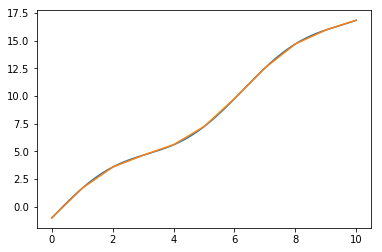

In [114]:
yy = np.zeros(len(xx)) # con estos valores ya podemos construir la
yy = np.array([sum([wi(z,x,i)*Y[i-1] for i in range(1,nx)]) for z in xx])
# sumatoria, a la que añadimos las dos func. de base de los extremos
yy = yy +    ya*np.array([w0(z,x) for z in xx]) # izquierdo y
yy = yy + Y[-1]*np.array([wn(z,x) for z in xx]) # derecho
# multiplicadas por los coeficientes apropiados
plt.plot(xx,yyexacta); # para poder recuperar las condiciones
plt.plot(xx,yy); # de contorno del problema de partida

# Caso de condiciones mixtas (de tipo Robin)

#### Posibilidad de proponer como ejercicio este caso

Resolveremos finalmente la misma ecuación diferencial anterior, pero con alguna de las condiciones de tipo Robin (o mixto), aunque la otra siga siendo de tipo Dirichlet en alguno de los dos extremos de cierto intervalo $[a,b]$, con lo cuál seguimos teniendo asegurada la unicidad de la correspondiente solución; pongamos por ejemplo (con $|\alpha_b|+|\beta_b|\neq 0$)

$$-y''(x) = f(x), \; x\in [a,b]\\
y(a) = y_a,\quad \alpha_b y(b)+\beta_b y'(b)=\widehat{y}_b$$

para cierta función $f(x)$ continua en dicho intervalo. Seguiremos tomando $f(x)=\sin(x),\; x\in[0,10]$ como antes.

**Comentario:** Nótese que si $\beta_b = 0$ entonces la condición de tipo Robin se reduciría a una condición de tipo Dirichlet estandard ($y(b)=\frac{\widehat{y}_b}{\alpha_b}$), mientras que si por el contrario $\alpha_b = 0$ entonces dicha condición se convierte en una condición de tipo Neumann ($y'(b)=\frac{\widehat{y}_b}{\beta_b}$); así pues, consideraremos $\alpha_b, \beta_b\neq 0$ a partir de ahora.

In [115]:
a,b = sp.symbols('a,b')

In [116]:
alpha_b = 1; beta_b =1;

In [117]:
C1,C2 = sp.symbols('C1,C2')

In [118]:
solgen  # la solución general de la ec. diferencial era

In [119]:
print(solgen)

Eq(y(z), C1 + C2*z + sin(z))


In [120]:
print(sp.diff(C1 + C2*z + sp.sin(z),z)) # usaremos la variable z
# que ya la teníamos definida como simbólica, ya que x era un array

C2 + cos(z)


In [121]:
ya,yb = sp.symbols('ya,yb')
ecs = (C1 + C2*z + sp.sin(z)).subs({z:a})-ya,(alpha_b*(C1 + C2*z + sp.sin(z)).subs({z:b})+beta_b*(C2 + sp.cos(z)).subs({z:b}))-yb
ecs  # continuar a partir de aquí

In [122]:
solgen = solgen.subs({C1:ya})
solgen

In [123]:
(alpha_b*(C2*z + sp.sin(z)).subs({z:b})+beta_b*(C2 + sp.cos(z)).subs({z:b}))-yb

In [124]:
print(_)

C2*b + C2 - yb + sin(b) + cos(b)


In [125]:
def yexacta(z,ya,yb):
    """solución exacta del problema tomado como ejemplo"""
    return ya + z*(yb - sp.cos(10)) + sp.sin(z)

In [126]:
a = 0; b = 10;
ya = -1; yb = 1
yexacta(z,ya,yb)

In [127]:
sp.diff(yexacta(z,ya,dyb),z,2)

In [128]:
sp.diff(yexacta(z,ya,dyb),z).subs({z:b})

In [129]:
# comprobación
sp.diff(yexacta(z,ya,dyb),z,2)

In [130]:
yexacta(a,ya,dyb),sp.diff(yexacta(z,ya,dyb),z).subs({z:b})

Buscaremos soluciones aproximadas de la siguiente forma  
$$\widetilde{y}_h(x) = y_0 w_0(x)+ \sum_{j=1}^{n}y_j w_j(x)\equiv y_a w_0(x)+\widetilde{z}_h(x),$$ con el valor $y_0=y_a$ fijado a partir de la condición de tipo Dirichlet dada en ese extremo izquierdo del intervalo, mientras que tendremos que dejar $y_n$ libre, por la condición de tipo mixto impuesta en el otro extremo del intervalo.  Como es habitual, usaremos las funciones de base $w_i(x),\, i=0,1,\ldots, n$ para este E.F. de Lagrange lineal.

En este caso pues, también se deberá satisfacer la correspondiente formulación variacional del problema correspondiente a una condición de tipo Robin: $\alpha_b y(b)+\beta_b y'(b)=\widehat{y}_b$ en el extremo derecho del intervalo $[a,b]$ (con $\beta_b\neq 0$), a saber

$$\mathcal{A}(\widetilde{y}_h,w_i)
+w_i(b)\widetilde{y}_h(b)\frac{\alpha_b}{\beta_b}
=\mathcal{B}_{f}(w_i)+w_i(b)\frac{\widehat{y}_b}{\beta_b},\; \forall i =1,\ldots,n$$

donde ahora podríamos escribir $\widetilde{\mathcal{A}}(w_i,w_j)\equiv\mathcal{A}(w_i,w_j)
+w_i(b)\, w_j(b)\,\frac{\alpha_b}{\beta_b}$  y
$\widetilde{\mathcal{B}}_{f}(w_i)\equiv\mathcal{B}_{f}(w_i)+ w_i(b)\frac{\widehat{y}_b}{\beta_b}$; pero claramente estos nuevos  sumandos sólo cambiarán algo cuando ni $w_i(b)$ ni $w_j(b)$ se anule; es decir para los índices $i=j=n$.

Usando además la bilinealidad de la forma cuadrática $\mathcal{A}$ nos quedaría $\forall i =1,\ldots,n$ que

$$\widetilde{\mathcal{B}}_{f}(w_i)= \int_a^b f(x)w_i(x)\,dx + w_i(b)\frac{\widehat{y}_b}{\beta_b}\\
= \widetilde{\mathcal{A}}(y_a w_0+ \sum_{j=1}^{n}y_j w_j,w_i) \\
=y_a \mathcal{A}(w_0,w_i)+w_0(b)\,w_i(b)\,\frac{\alpha_b}{\beta_b}\\
+\sum_{j=1}^{n}y_j \mathcal{A}(w_j,w_i)
+w_i(b)\,w_j(b)\, \frac{\alpha_b}{\beta_b}$$

pero claramente todos los elementos $w_i(b)=w_j(b)=0,\; \forall i=1,\ldots,n$ y $\mathcal{A}(w_0,w_i)$ también serán nulos salvo en todo caso el correspondiente a $i=1$
$$\mathcal{A}(w_0,w_1)=-\frac{1}{x_1-x_0}.$$

Así pues, tan sólo tendríamos que modificar el primer elemento del vector de cargas, sumándole el siguiente término:

$$-y_a\mathcal{A}(w_0,w_1) = +\frac{y_a}{x_1-x_0}$$

En cuanto a los términos $w_i(b)\,w_j(b)\,\frac{\alpha_b}{\beta_b}$, nótese que todos se anularían también, salvo el caso $i=j=n$; por lo tanto esto provocaría que cambie tan sólo el último elemento de la diagonal de la matriz de rígidez: 
$\widetilde{\mathcal{A}}(w_n,w_n) = \mathcal{A}(w_n,w_n) +\,\frac{\alpha_b}{\beta_b}$.


**Ejercicio (obligatorio):** Terminar de implementar el código correspondiente a la resolución numérica aproximada de un problema como este con condiciones de contorno de tipo Robin, en uno de los extremos del intervalo y resuelva el correspondiente problema con $a=0$, $b=d_1$, $y_a=d_2$, $\alpha_b = d_3$, $\beta_b = d_4$ e $\widehat{y}_b = d_5$, si el último dígito de su DNI es par, o bien $a=0$, $b=d_1$, $y_b=d_2$, $\alpha_a = d_3$, $\beta_a = d_4$ e $\widehat{y}_a = d_5$, si el último dígito de su DNI es impar (siendo $d_i$ (con $i=1,\ldots 8$) el dígito de su DNI o pasaporte situado en la posición i-ésima).

**Ejercicio (optativo):** Estudiar y/o implementar también el código correspondiente a la resolución numérica aproximada de un problema autoadjunto general

$$\mathcal{L}(y)\equiv -(p(x)y')'+q(x)y= f(x), \; x\in [a,b]$$

para cierta función $f(x)$ continua en dicho intervalo, con funciones $p\in\mathcal{C}^1$ y $q\in\mathcal{C}^0$) y con diferentes condiciones de contorno de tipo Dirichlet, Neumann y/o Robin, en cada uno de los extremos del intervalo.

**Ejercicio (optativo):** Estudiar y/o implementar ahora el código correspondiente a la resolución numérica aproximada de un problema de cuarto orden (usando por ejempplo el E.F de Hermite de clase $\mathcal{C}^1$)

$$\mathcal{L}(y)\equiv (p(x)\,y'')''-(q(x)\,y')'+r(x)\,y(x)= f(x), \; x\in [a,b]$$

con funciones $p,\,q,\,r,\, f$ suficientemente regulares y con diferentes condiciones de contorno de tipo Dirichlet y/o Neumann en cada uno de los extremos del intervalo, estudiando qué ocurre con las formulaciones variacionales correspondientes cuando se elimina alguna de ellas. 

**Comentario:** Esta misma técnica de Galerkin también se podría emplear en el caso de operadores diferenciales no autoadjuntos 
$$\mathcal{L}(y)\equiv a_0(x)y''+a_1(x)y'+a_2(x)y= c(x), \; x\in [a,b]$$
aunque a priori podrían dar lugar a sistemas lineales no simétricos, salvo que $a_0(x)\neq 0 $ en el intervalo $[a,b]$ y multipliquemos la ecuación, previamente dividiendolo todo entre $a_0(x)$, por el factor $p(x):=-e^{\int_a^x \frac{a_1(\xi)}{a_0(\xi)}\,d\xi}$, con $q(x)=-p'(x)=p(x)\frac{a_1(x)}{a_0(x)}$ y $f(x)\equiv \frac{c(x)}{a_0(x)}$, quedando finalmente en forma autoadjunta:

$$\mathcal{L}(y)\equiv -(p(x)y')'+q(x)y= f(x), \; x\in [a,b]$$